<a href="https://colab.research.google.com/github/bartteeuwen/USD-Applied-Data-Science-for-Business/blob/main/Agentic_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install libraries
%pip install -q datasets transformers scikit-learn pandas matplotlib

# Disable W&B prompts
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Setup & imports
import os, json, math, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay)

# random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
from huggingface_hub import login
from google.colab import userdata

try:
    token = userdata.get('HF_TOKEN')
    login(token)
except Exception:
    # If the stakeholder doesn't have the secret, they get a login prompt
    login()

In [ ]:
# Load APIGen
from datasets import load_dataset
apigen = load_dataset("Salesforce/APIGen-MT-5K", split="train")
len(apigen), apigen[0].keys()

(5000, dict_keys(['conversations', 'tools', 'system']))

In [ ]:
# Helper columns that turn raw conversation logs into modeling tables:
# (1) Parse APIGen turns (human/agent/function_call/observation)
# (2) Build a leakage-safe text window of the *past* context
# (3) Create Stage-1 pairs (context → CALL_TOOL vs NO_TOOL)
# (4) Create Stage-2 pairs (context → which tool), and
# (5) Optionally bucket infrequent tools into RARE_TOOL to keep splits viable.

import json
import numpy as np
from collections import Counter

# Lightweight accessors for a single conversation example
def get_traj(example):
    # Return the list of turns for one conversation (empty list if missing)
    return example.get("conversations", []) or []

def get_role(turn):
    # Who/what produced the turn: "human", "gpt", "function_call", or "observation"
    return turn.get("from")

def get_text(turn):
    # Raw text/value associated with the turn (dialog text or JSON string)
    return turn.get("value")

def get_tool_name(turn):
    # If the turn is a function_call, parse the JSON and pull the "name" of the tool
    if get_role(turn) == "function_call":
        try:
            obj = json.loads(turn["value"])
            return obj.get("name")
        except Exception:
            return None
    return None

def get_result_text(turn):
    # If the turn is an observation (tool output), return its text blob; else None
    return get_text(turn) if get_role(turn) == "observation" else None

# Tags used to mark roles and tool activity in the serialized context
SEP_USR, SEP_AGT, SEP_TOOL, SEP_RES = "[USR]", "[AGENT]", "[TOOL]", "[RESULT]"

def serialize_context(traj, i, max_turns=6):
    """
    Build a leakage-safe text window from the *past* (turns [:i]) for modeling.
    - Keeps only the last `max_turns` turns for compactness
    - Adds [USR]/[AGENT] before dialog text
    - Adds [TOOL] <tool_name> when a function_call occurs
    - Adds [RESULT] plus a short snippet of the observation (not the full JSON)
    """
    pieces = []
    turns = traj[:i][-max_turns:]  # last few turns before position i
    for t in turns:
        role = get_role(t)
        val  = get_text(t)
        if role == "human":
            pieces += [SEP_USR, val]
        elif role == "gpt":
            pieces += [SEP_AGT, val]
        elif role == "function_call":
            tool = get_tool_name(t)
            if tool:
                pieces += [SEP_TOOL, tool]
        elif role == "observation":
            # Use a short preview only to avoid leaking long/structured outputs
            pieces += [SEP_RES, str(val)[:200]]
    return " ".join(pieces).strip()

# build (X, y) where y = 1 if the *next* turn is a tool call
def build_stage1_pairs(ds):
    """
    Returns:
      X1_all: serialized contexts up to each position
      y1_all: binary labels (1=function_call next, 0 otherwise)
    """
    X, y = [], []
    for ex in ds:
        traj = get_traj(ex)
        for i in range(1, len(traj)):          # i points to the *next* turn
            X.append(serialize_context(traj, i))
            y.append(1 if get_role(traj[i]) == "function_call" else 0)
    return X, np.array(y, dtype=int)

# build (X, y) for rows where the *next* turn is a tool call
def build_stage2_pairs(ds):
    """
    Returns:
      X2_all: serialized contexts (same construction as Stage 1)
      y2_all: tool name labels for positions where the next turn is a tool call
    """
    X, y = [], []
    for ex in ds:
        traj = get_traj(ex)
        for i in range(1, len(traj)):
            nxt = traj[i]
            if get_role(nxt) == "function_call":
                tool = get_tool_name(nxt)
                if tool:
                    X.append(serialize_context(traj, i))
                    y.append(tool)
    return X, np.array(y)

# collapse infrequent tool labels to "RARE_TOOL" for robust splits
def map_rare_labels(y, min_count=10):
    cnt = Counter(y)
    return np.array([lbl if cnt[lbl] >= min_count else "RARE_TOOL" for lbl in y])

**EDA**

EDA table shape: (87311, 4)


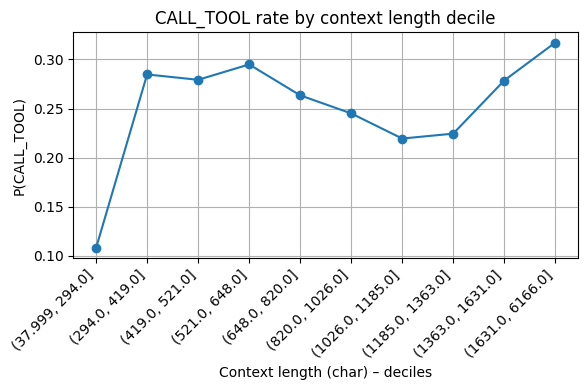

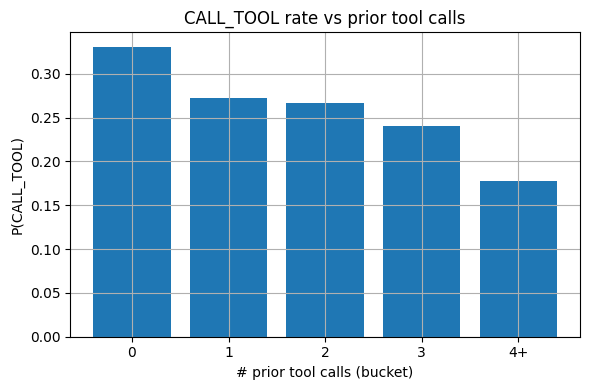

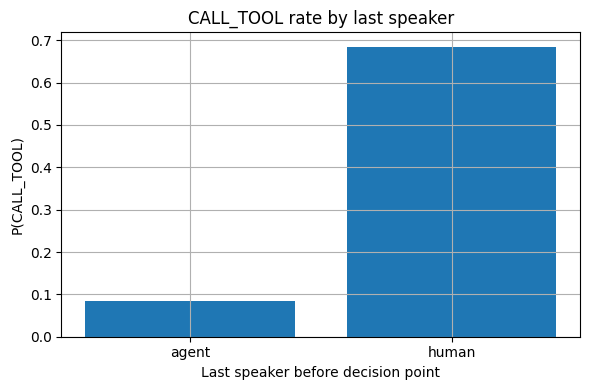

,predictor,chi2,p_value,cramers_v
0,len_decile,1456.000027,6.130798e-308,0.129136
1,prior_calls_bucket,1227.626855,1.632897e-264,0.118973
2,last_speaker,33395.878066,0.000000e+00,0.618460


,test,H_stat,p_value
0,Kruskal–Wallis (ctx_len by y),248.184214,6.461050e-56


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, kruskal

plt.rcParams.update({"figure.figsize": (6, 4), "axes.grid": True})

# Build table directly from conversations
def last_speaker_before_i(traj, i) -> str:
    """Return 'human' or 'agent' for the previous speaker at position i-1."""
    if i == 0:
        return "none"
    return "human" if get_role(traj[i-1]) == "human" else "agent"

def count_prior_function_calls(traj, i) -> int:
    """How many function_call turns occurred strictly before i?"""
    return sum(1 for t in traj[:i] if get_role(t) == "function_call")

def context_text_length(traj, i, max_turns=6) -> int:
    """Length of the serialized context window used later for modeling (chars)."""
    return len(serialize_context(traj, i, max_turns=max_turns))

rows = []
for ex in apigen:
    traj = get_traj(ex)
    for i in range(1, len(traj)):
        # outcome: is the next turn a tool call?
        y_calltool = 1 if get_role(traj[i]) == "function_call" else 0
        rows.append({
            "y_calltool": y_calltool,
            "ctx_len_chars": context_text_length(traj, i, max_turns=6),
            "prior_calls":   count_prior_function_calls(traj, i),
            "last_speaker":  last_speaker_before_i(traj, i)
        })

eda = pd.DataFrame(rows)
print("EDA table shape:", eda.shape)

# Bin the simple predictors
eda["len_decile"] = pd.qcut(eda["ctx_len_chars"], q=10, duplicates="drop")
eda["prior_calls_bucket"] = pd.cut(eda["prior_calls"], bins=[-1,0,1,2,3,10], labels=["0","1","2","3","4+"])
eda["last_speaker"] = eda["last_speaker"].replace({"none": "human"})  # rare edge → group those with human

# Chart showing CALL_TOOL rate by context length decile
rate_by_len = eda.groupby("len_decile", observed=False)["y_calltool"].mean().reset_index()
plt.figure()
plt.plot(rate_by_len["len_decile"].astype(str), rate_by_len["y_calltool"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Context length (char) – deciles")
plt.ylabel("P(CALL_TOOL)")
plt.title("CALL_TOOL rate by context length decile")
plt.tight_layout()
plt.show()

# Chart showing CALL_TOOL rate vs prior tool calls
rate_by_prior = eda.groupby("prior_calls_bucket", observed=False)["y_calltool"].mean().reset_index()
plt.figure()
plt.bar(rate_by_prior["prior_calls_bucket"].astype(str), rate_by_prior["y_calltool"])
plt.xlabel("# prior tool calls (bucket)")
plt.ylabel("P(CALL_TOOL)")
plt.title("CALL_TOOL rate vs prior tool calls")
plt.tight_layout()
plt.show()

# Chart showing CALL_TOOL rate by last speaker
rate_by_speaker = eda.groupby("last_speaker", observed=False)["y_calltool"].mean().reset_index()
plt.figure()
plt.bar(rate_by_speaker["last_speaker"], rate_by_speaker["y_calltool"])
plt.xlabel("Last speaker before decision point")
plt.ylabel("P(CALL_TOOL)")
plt.title("CALL_TOOL rate by last speaker")
plt.tight_layout()
plt.show()

# Table showing Chi-square + Cramér’s V for categorical predictors
def chisq_cramers_v(cat_col, y_col):
    ct = pd.crosstab(eda[cat_col], eda[y_col])
    chi2, p, _, _ = chi2_contingency(ct)
    n = ct.to_numpy().sum()
    r, k = ct.shape
    cramers_v = np.sqrt((chi2 / n) / (min(r, k) - 1))
    return chi2, p, cramers_v

chi_len, p_len, v_len = chisq_cramers_v("len_decile", "y_calltool")
chi_prior, p_prior, v_prior = chisq_cramers_v("prior_calls_bucket", "y_calltool")
chi_speaker, p_speaker, v_speaker = chisq_cramers_v("last_speaker", "y_calltool")

tbl_pred = pd.DataFrame({
    "predictor": ["len_decile", "prior_calls_bucket", "last_speaker"],
    "chi2": [chi_len, chi_prior, chi_speaker],
    "p_value": [p_len, p_prior, p_speaker],
    "cramers_v": [v_len, v_prior, v_speaker],
})
display(tbl_pred)

# Table showing Kruskal–Wallis test for length (distribution-free)
# Compare ctx_len_chars distribution by outcome
h_stat, p_kw = kruskal(
    eda.loc[eda["y_calltool"]==0, "ctx_len_chars"],
    eda.loc[eda["y_calltool"]==1, "ctx_len_chars"]
)
tbl_kw = pd.DataFrame([{"test": "Kruskal–Wallis (ctx_len by y)", "H_stat": h_stat, "p_value": p_kw}])
display(tbl_kw)

**Modeling**

In [ ]:
# Build Stage-1 table
X1_all, y1_all = build_stage1_pairs(apigen)
print("Stage-1 table:", len(X1_all))

# Train/val/test split (80/10/10), stratified
X1_tr, X1_tmp, y1_tr, y1_tmp = train_test_split(X1_all, y1_all, test_size=0.20, random_state=42, stratify=y1_all)
X1_val, X1_te,  y1_val, y1_te  = train_test_split(X1_tmp, y1_tmp, test_size=0.50, random_state=42, stratify=y1_tmp)
print("Stage-1 sizes:", len(X1_tr), len(X1_val), len(X1_te))

# Build Stage-2 table (tool-calls only) and rare-merge
X2_all_raw, y2_all_raw = build_stage2_pairs(apigen)
y2_all = map_rare_labels(y2_all_raw, min_count=10)
print("Stage-2 raw:", len(X2_all_raw), " | after rare-merge:", len(y2_all))

# Train/val/test split for Stage-2 (stratified by merged labels)
X2_tr, X2_tmp, y2_tr, y2_tmp = train_test_split(X2_all_raw, y2_all, test_size=0.20, random_state=42, stratify=y2_all)
X2_val, X2_te,  y2_val, y2_te  = train_test_split(X2_tmp, y2_tmp,  test_size=0.50, random_state=42, stratify=y2_tmp)
print("Stage-2 sizes:", len(X2_tr), len(X2_val), len(X2_te))

# For false-activation analysis build a Stage-2 "non-tool context" set from Stage-1 val rows with NO_TOOL next
X2_neg_val = [X1_val[i] for i in range(len(X1_val)) if y1_val[i] == 0]
len(X2_neg_val)

Stage-1 table: 87311
Stage-1 sizes: 69848 8731 8732
Stage-2 raw: 21955  | after rare-merge: 21955
Stage-2 sizes: 17564 2195 2196


6536

LogReg    val_accuracy=0.790  macro_f1=0.748
ElasticN  val_accuracy=0.810  macro_f1=0.772


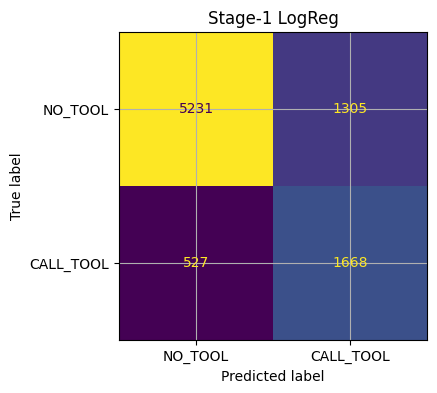

In [ ]:
# Stage 1 build baseline Logistic Regression (L2), TF-IDF (1,2)
stage1 = Pipeline([
    ("tf", TfidfVectorizer(max_features=50_000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced", n_jobs=1, random_state=42)),
]).fit(X1_tr, y1_tr)

# Stage 1 build baseline alternative using Elastic-Net Logistic Regression (saga solver)
stage1_enet = Pipeline([
    ("tf", TfidfVectorizer(max_features=50_000, ngram_range=(1,2))),
    ("clf", LogisticRegression(penalty="elasticnet", solver="saga",
                               l1_ratio=0.2, max_iter=300, class_weight="balanced",
                               n_jobs=1, random_state=42)),
]).fit(X1_tr, y1_tr)

# Quick metrics for validation
def print_stage1_metrics(model, Xv, yv, label):
    pred = model.predict(Xv)
    print(f"{label}  val_accuracy={accuracy_score(yv, pred):.3f}  macro_f1={f1_score(yv, pred, average='macro'):.3f}")

print_stage1_metrics(stage1,      X1_val, y1_val, "LogReg  ")
print_stage1_metrics(stage1_enet, X1_val, y1_val, "ElasticN")

# Confusion matrix for baseline (optional)
cm = confusion_matrix(y1_val, stage1.predict(X1_val), labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["NO_TOOL","CALL_TOOL"]).plot(colorbar=False); plt.title("Stage-1 LogReg"); plt.show()


In [ ]:
# Helper block that computes evaluation metrics for two-stage system—top-k accuracy,
# Stage-1 threshold sweeps (τ₁ → call-rate/precision/recall/F1),
# Stage-2 threshold sweeps (τ₂ → coverage/acted-case accuracy), and a joint grid that combines Stage-1 and Stage-2 to report
# overall coverage/accuracy across (τ₁, τ₂) settings (optionally including a per-1k “expected value” score).

def label_indexer(classes):
    return {c:i for i,c in enumerate(classes)}

def topk_accuracy_from_proba(proba, y_true, classes, k=1):
    idx = label_indexer(classes)
    y_idx = np.array([idx[y] for y in y_true])
    topk = np.argsort(-proba, axis=1)[:, :k]
    return float((topk == y_idx[:,None]).any(axis=1).mean())

def stage1_tau1_sweep(proba_calltool, y_true, thresholds):
    rows=[]
    for t in thresholds:
        pred = (proba_calltool >= t).astype(int)
        rows.append({
            "tau1": t,
            "call_rate": float(pred.mean()),
            "precision_CALL_TOOL": float(precision_score(y_true, pred, zero_division=0)),
            "recall_CALL_TOOL":    float(recall_score(y_true,  pred, zero_division=0)),
            "f1_CALL_TOOL":        float(f1_score(y_true,     pred, zero_division=0)),
        })
    return pd.DataFrame(rows)

def stage2_tau2_sweep(proba, y_true, classes, thresholds):
    idx  = label_indexer(classes)
    yidx = np.array([idx[y] for y in y_true])
    rows=[]
    for t in thresholds:
        mask = proba.max(axis=1) >= t
        cov  = float(mask.mean())
        if cov == 0.0:
            acted_acc = np.nan
        else:
            pred_idx = proba[mask].argmax(axis=1)
            acted_acc = float((pred_idx == yidx[mask]).mean())
        rows.append({"tau2": t, "coverage": cov, "acted_accuracy": acted_acc})
    return pd.DataFrame(rows)

def joint_grid(stage1_proba, y1_true, proba_tool, y2_true, proba_non, classes2,
               tau1_grid=(0.4,0.5,0.6,0.7,0.8),
               tau2_grid=(0.5,0.6,0.7,0.8,0.9)):
    """
    Evaluate joint performance for Stage-1 (when to act) and Stage-2 (which tool to pick),
    across a grid of thresholds (τ₁, τ₂). Returns precision, coverage, and accuracy metrics.
    """
    idx2  = label_indexer(classes2)
    y2idx = np.array([idx2[y] for y in y2_true])

    def acc_cov_on_toolcalls(proba, y_idx, thr):
        mask = proba.max(axis=1) >= thr
        if not mask.any():
            return 0.0, 0.0
        acc = float((proba[mask].argmax(axis=1) == y_idx[mask]).mean())
        cov = float(mask.mean())
        return acc, cov

    def false_act_rate_on_non(max_conf, thr):
        return float((max_conf >= thr).mean())

    rows = []
    max_conf_non = proba_non.max(axis=1)
    for t1 in tau1_grid:
        call_mask = (stage1_proba >= t1)
        call_rate = float(call_mask.mean())
        prec1     = float(precision_score(y1_true, call_mask.astype(int), zero_division=0))
        for t2 in tau2_grid:
            acc2, cov2 = acc_cov_on_toolcalls(proba_tool, y2idx, t2)
            f_non      = false_act_rate_on_non(max_conf_non, t2)
            coverage   = call_rate * (prec1 * cov2 + (1 - prec1) * f_non)
            successes  = call_rate * prec1 * cov2 * acc2
            overall_acc = (successes / coverage) if coverage > 0 else 0.0
            rows.append({
                "tau1": t1, "tau2": t2,
                "stage1_call_rate": call_rate,
                "stage1_precision": prec1,
                "stage2_acc_toolcalls": acc2,
                "stage2_cov_toolcalls": cov2,
                "stage2_false_act_non_tool": f_non,
                "overall_coverage": coverage,
                "overall_accuracy": overall_acc
            })
    return pd.DataFrame(rows)

model,ElasticNet LR,LogReg
tau1,,
0.3,0.523,0.513
0.4,0.603,0.581
0.5,0.678,0.646
0.6,0.685,0.645
0.7,0.573,0.535
0.8,0.348,0.315


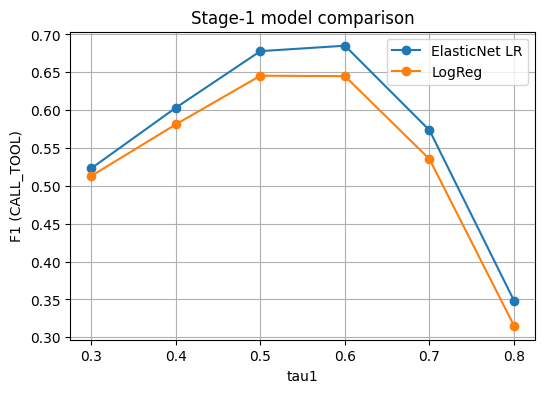

In [ ]:
# Code compares two Stage-1 models (Elastic-Net LR vs. Logistic Regression) by sweeping the gate threshold τ₁ on the validation set,
# computing F1 at each threshold, then showing a table of F1-by-τ₁ and a plot to visualize which model performs better across thresholds.

tau1_grid = [0.30,0.40,0.50,0.60,0.70,0.80]

proba1_log  = stage1.predict_proba(X1_val)[:,1]
proba1_enet = stage1_enet.predict_proba(X1_val)[:,1]

df_log  = stage1_tau1_sweep(proba1_log,  y1_val, tau1_grid)
df_enet = stage1_tau1_sweep(proba1_enet, y1_val, tau1_grid)

# Table (F1 focus)
cmp = pd.concat(
    [df_enet.assign(model="ElasticNet LR"),
     df_log.assign(model="LogReg")],
    ignore_index=True
)

tbl = cmp.pivot(index="tau1", columns="model", values="f1_CALL_TOOL").round(3)
display(tbl)

plt.figure()
plt.plot(df_enet["tau1"], df_enet["f1_CALL_TOOL"], marker="o", label="ElasticNet LR")
plt.plot(df_log["tau1"],  df_log["f1_CALL_TOOL"],  marker="o", label="LogReg")
plt.xlabel("tau1"); plt.ylabel("F1 (CALL_TOOL)"); plt.title("Stage-1 model comparison")
plt.grid(True); plt.legend(); plt.show()

,label,precision,recall,f1-score,support
14,get_order_details,0.794,0.833,0.813,407.0
16,get_product_details,0.715,0.881,0.789,293.0
18,get_user_details,0.430,0.212,0.284,189.0
11,find_user_id_by_email,0.887,0.957,0.921,188.0
12,find_user_id_by_name_zip,0.886,0.972,0.927,176.0
22,modify_pending_order_items,0.778,0.902,0.835,163.0
17,get_reservation_details,0.812,0.812,0.812,160.0
5,exchange_delivered_order_items,0.827,0.921,0.871,151.0
29,think,0.415,0.318,0.360,85.0
26,search_direct_flight,0.542,0.510,0.525,51.0


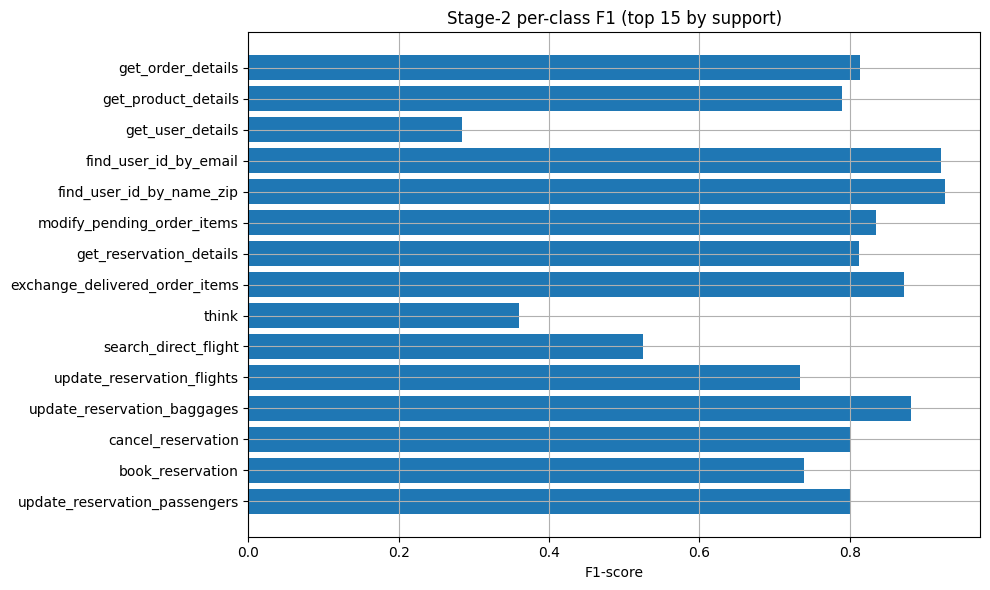

<Figure size 1000x800 with 0 Axes>

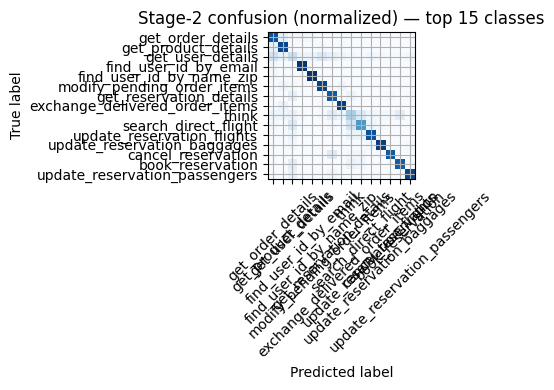

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Code trains a stage 2 TF-IDF -> SGD (elastic net, log loss) classifier, calibrates its probabilities with
# sigmoid (CalibratedClassifierCV), and reports macro-F1 on the validation set with a confusion matrix
stage2_base = Pipeline([
    ("tf",  TfidfVectorizer(max_features=50_000, ngram_range=(1,2), dtype=np.float32)),
    ("clf", SGDClassifier(loss="log_loss", penalty="elasticnet",
                          alpha=1e-4, l1_ratio=0.15, class_weight="balanced",
                          max_iter=500, tol=1e-3,
                          early_stopping=True, validation_fraction=0.1,
                          n_iter_no_change=5, random_state=42))
])

stage2 = CalibratedClassifierCV(stage2_base, method="sigmoid", cv=3).fit(X2_tr, y2_tr)

# quick per-class report on val (optional)
pred2 = stage2.predict(X2_val)

report = classification_report(y2_val, pred2, output_dict=True, zero_division=0)
per_class = (
    pd.DataFrame(report)
      .T
      .reset_index()
      .rename(columns={"index":"label"})
)
# keep only real labels (filter out 'accuracy', 'macro avg', 'weighted avg')
per_class = per_class[~per_class["label"].isin(["accuracy","macro avg","weighted avg"])]

# Sort by support and show top-N most frequent classes
TOP_N = 15
topN = per_class.sort_values("support", ascending=False).head(TOP_N)

display(topN[["label","precision","recall","f1-score","support"]].round(3))

# Bar chart: per-class F1 (top-N)
plt.figure(figsize=(10,6))
plt.barh(topN["label"][::-1], topN["f1-score"][::-1])
plt.xlabel("F1-score")
plt.title(f"Stage-2 per-class F1 (top {TOP_N} by support)")
plt.tight_layout()
plt.show()

# pick the same TOP_N labels by support
labels_topN = topN["label"].tolist()

# mask data to those labels
mask_true = y2_val.isin(labels_topN) if hasattr(y2_val, "isin") else np.isin(y2_val, labels_topN)
mask_pred = pred2 == pred2  # all
y_true_top = np.array(y2_val)[mask_true]
y_pred_top = np.array(pred2)[mask_true]

cm = confusion_matrix(y_true_top, y_pred_top, labels=labels_topN, normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=labels_topN)

plt.figure(figsize=(10,8))
disp.plot(include_values=False, cmap="Blues", xticks_rotation=45, colorbar=False)
plt.title(f"Stage-2 confusion (normalized) — top {TOP_N} classes")
plt.tight_layout()
plt.show()


**Data Wrangling & Pre-Processing**

{'top1': 0.758, 'top3': 0.943, 'top5': 0.978}


,tau2,coverage,acted_accuracy
0,0.50,0.830979,0.822368
1,0.60,0.711617,0.873880
2,0.70,0.589066,0.901779
3,0.80,0.404100,0.943630
4,0.90,0.102506,0.968889
5,0.95,0.044647,0.989796


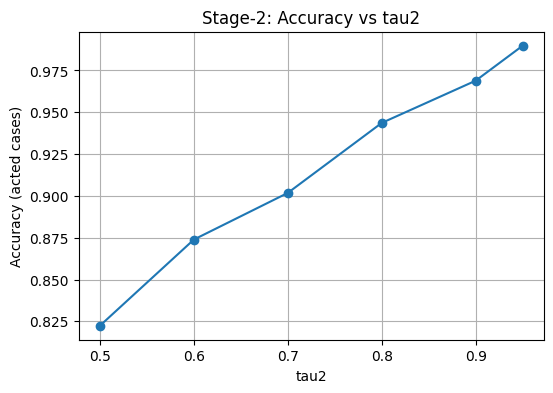

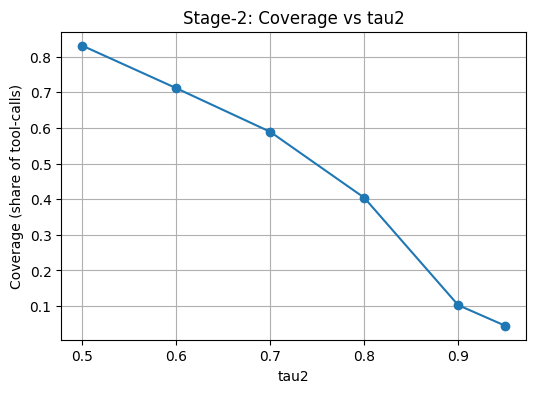

In [ ]:
# Grabs stage-2 class probabilities, computes top-k accuracy, sweeps confidence thresholds τ₂ to create acted-case accuracy and coverage,
# and plots the accuracy-vs-τ₂ and coverage-vs-τ₂ trade-offs.
proba2_val = stage2.predict_proba(X2_val)
classes2   = stage2.classes_

top1 = topk_accuracy_from_proba(proba2_val, y2_val, classes2, k=1)
top3 = topk_accuracy_from_proba(proba2_val, y2_val, classes2, k=3)
top5 = topk_accuracy_from_proba(proba2_val, y2_val, classes2, k=5)
print({"top1": round(top1,3), "top3": round(top3,3), "top5": round(top5,3)})

tau2_grid = [0.50,0.60,0.70,0.80,0.90,0.95]
df_tau2 = stage2_tau2_sweep(proba2_val, y2_val, classes2, tau2_grid)
display(df_tau2)

# quick plots
plt.figure(); plt.plot(df_tau2["tau2"], df_tau2["acted_accuracy"], marker="o")
plt.xlabel("tau2"); plt.ylabel("Accuracy (acted cases)"); plt.title("Stage-2: Accuracy vs tau2"); plt.grid(True); plt.show()

plt.figure(); plt.plot(df_tau2["tau2"], df_tau2["coverage"], marker="o")
plt.xlabel("tau2"); plt.ylabel("Coverage (share of tool-calls)"); plt.title("Stage-2: Coverage vs tau2"); plt.grid(True); plt.show()

,tau1,tau2,stage1_call_rate,stage1_precision,stage2_acc_toolcalls,stage2_cov_toolcalls,stage2_false_act_non_tool,overall_coverage,overall_accuracy
24,0.8,0.9,0.051540,0.926667,0.968889,0.102506,0.028764,0.005004,0.947841
19,0.7,0.9,0.116596,0.844794,0.968889,0.102506,0.028764,0.010617,0.921388
23,0.8,0.8,0.051540,0.926667,0.943630,0.404100,0.192013,0.020026,0.909433
14,0.6,0.9,0.207880,0.712397,0.968889,0.102506,0.028764,0.016900,0.870298
18,0.7,0.8,0.116596,0.844794,0.943630,0.404100,0.192013,0.043278,0.867868
22,0.8,0.7,0.051540,0.926667,0.901779,0.589066,0.380049,0.029571,0.857973
21,0.8,0.6,0.051540,0.926667,0.873880,0.711617,0.553244,0.036079,0.823231
17,0.7,0.7,0.116596,0.844794,0.901779,0.589066,0.380049,0.064900,0.806217
9,0.5,0.9,0.340511,0.561049,0.968889,0.102506,0.028764,0.023882,0.794471
13,0.6,0.8,0.207880,0.712397,0.943630,0.404100,0.192013,0.071324,0.791750


Best operating point: {'tau1': np.float64(0.8), 'tau2': np.float64(0.9), 'overall_coverage': np.float64(0.005), 'overall_accuracy': np.float64(0.948)}


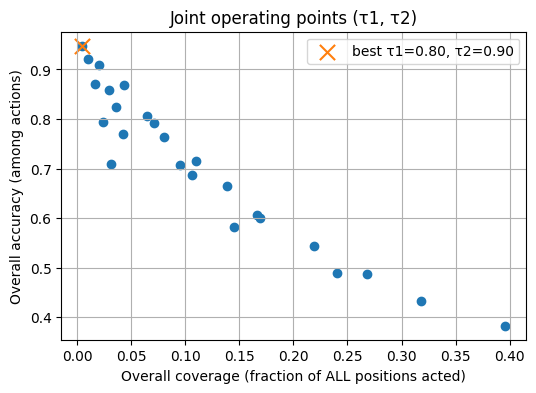

In [ ]:
# Code grabs stage-2 class probabilities, computes top-k accuracy (k = 1/3/5), sweeps confidence thresholds τ₂ to tabulate acted-case accuracy and
# coverage and plots the accuracy-vs-τ₂ and coverage-vs-τ₂ trade-offs.
proba2_non = stage2.predict_proba(X2_neg_val)

df_joint = joint_grid(stage1.predict_proba(X1_val)[:,1], y1_val,
                      proba2_val, y2_val, proba2_non, classes2,
                      tau1_grid=[0.4,0.5,0.6,0.7,0.8],
                      tau2_grid=[0.5,0.6,0.7,0.8,0.9])

# Remove the EV columns if present
df_joint = df_joint.drop(columns=[c for c in df_joint.columns if "exp_value" in c], errors="ignore")

# Sort by overall_accuracy instead of EV
display(df_joint.sort_values("overall_accuracy", ascending=False).head(12))

best = df_joint.sort_values("overall_accuracy", ascending=False).iloc[0]
print("Best operating point:",
      {k: round(best[k],3) for k in ["tau1","tau2","overall_coverage","overall_accuracy"]})

# Coverage vs accuracy scatter, highlight best point
plt.figure()
plt.scatter(df_joint["overall_coverage"], df_joint["overall_accuracy"])
plt.scatter([best["overall_coverage"]],[best["overall_accuracy"]],
            s=120, marker="x", label=f"best τ1={best['tau1']:.2f}, τ2={best['tau2']:.2f}")
plt.xlabel("Overall coverage (fraction of ALL positions acted)")
plt.ylabel("Overall accuracy (among actions)")
plt.title("Joint operating points (τ1, τ2)")
plt.grid(True); plt.legend(); plt.show()


In [ ]:
# Test evaluation for a fixed (tau1, tau2) operating point

import numpy as np
from sklearn.metrics import precision_score, accuracy_score

def acted_metrics_on_test(stage1, stage2, X1_te, y1_te, X2_te, y2_te, t1, t2):
    """
    Computes overall coverage and accuracy on the TEST set for the chosen (t1, t2) thresholds.
    - Stage 1 decides whether to attempt a tool call.
    - Stage 2 decides which tool to call, if Stage 1 fires.
    """

    # Stage 1: show the probability of calling a tool
    prob1_te = stage1.predict_proba(X1_te)[:, 1]
    pred_call = (prob1_te >= t1).astype(int)
    call_rate = float(pred_call.mean())       # share of all positions where a tool is attempted
    prec1     = float(precision_score(y1_te, pred_call, zero_division=0))  # P(true tool | CALL_TOOL)

    # Masks for splitting test set into true tool vs non-tool contexts
    true_tool_mask     = (y1_te == 1)
    true_non_tool_mask = ~true_tool_mask

    # Stage 2: Predictions on TRUE tool-call contexts only
    # X2_te and y2_te correspond exactly to true tool calls
    class_to_idx = {lbl: i for i, lbl in enumerate(stage2.classes_)}
    y2_idx = np.array([class_to_idx[y] for y in y2_te])  # map labels to indices

    proba2_true = stage2.predict_proba(X2_te)           # class probabilities on true tool calls
    conf_true   = proba2_true.max(axis=1)               # confidence of top prediction
    pred_idx    = proba2_true.argmax(axis=1)            # index of predicted tool

    # Act only if Stage 1 predicted CALL_TOOL AND Stage 2 confidence ≥ t2
    pred_call_on_true = pred_call[true_tool_mask]
    act_on_true_mask  = (pred_call_on_true == 1) & (conf_true >= t2)

    # Stage 2 coverage = fraction of true tool calls we act on
    cov2 = float(act_on_true_mask.mean()) if act_on_true_mask.size else 0.0

    # Stage 2 acted-case accuracy = accuracy on the tool calls actually acted on
    acc2 = float((pred_idx[act_on_true_mask] == y2_idx[act_on_true_mask]).mean()) if act_on_true_mask.any() else 0.0

    # False activations on NON-tool contexts, for non-tool contexts where Stage 1 predicts CALL_TOOL,
    # is also measured how often Stage 2 confidence also crosses t2.
    if true_non_tool_mask.any():
        proba2_false = stage2.predict_proba(list(np.array(X1_te, dtype=object)[true_non_tool_mask]))
        conf_false   = proba2_false.max(axis=1)
        pred_call_on_false = pred_call[true_non_tool_mask]
        if pred_call_on_false.any():
            f_non = float((conf_false[pred_call_on_false == 1] >= t2).mean())
        else:
            f_non = 0.0
    else:
        f_non = 0.0

    # Overall coverage & accuracy (combines tool & non-tool cases)
    # = call_rate * [ precision(tool) * coverage_on_true + (1 - precision) * false_act_rate_on_non_tool ]
    coverage   = call_rate * (prec1 * cov2 + (1.0 - prec1) * f_non)

    # Total successes among those actions = share of correct tool picks on true tool calls
    successes  = call_rate * (prec1 * cov2 * acc2)

    # Overall accuracy = successes / total actions
    overall_acc = float(successes / coverage) if coverage > 0 else 0.0

    return {
        "stage1_call_rate": call_rate,         # fraction of all positions attempted
        "stage1_precision": prec1,             # P(true tool | predicted CALL_TOOL)
        "stage2_cov_toolcalls": cov2,          # share of true tool-calls acted on
        "stage2_acc_toolcalls": acc2,          # accuracy among acted tool-calls
        "stage2_false_act_non_tool": f_non,    # false activation rate on non-tool contexts
        "overall_coverage": coverage,          # fraction of ALL positions acted on
        "overall_accuracy": overall_acc,       # accuracy among all actions
    }

# Run test evaluation with chosen thresholds where either wecuse “best” values from validation or hardcode them directly
tau1, tau2 = 0.5, 0.75
final_metrics = acted_metrics_on_test(stage1, stage2, X1_te, y1_te, X2_te, y2_te, tau1, tau2)
final_metrics

{'stage1_call_rate': 0.3364635822262941,
 'stage1_precision': 0.5609257998638529,
 'stage2_cov_toolcalls': 0.35655737704918034,
 'stage2_acc_toolcalls': 0.9348659003831418,
 'stage2_false_act_non_tool': 0.3116279069767442,
 'overall_coverage': 0.1133310303913249,
 'overall_accuracy': 0.5551027620404422}

**Reference:**
OpenAI. (2025). ChatGPT (Oct 2025 version) [Large language model]. OpenAI. https://chat.openai.com/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('''
<style>
    pre {
        white-space: pre-wrap !important;   /* wraps long lines */
        word-break: break-word;
    }
    .output_area pre {
        white-space: pre-wrap !important;
    }
</style>
'''))

In [ ]:
!jupyter nbconvert --to webpdf "Agentic_AI.ipynb" --allow-chromium-download

[NbConvertApp] Converting notebook Agentic_AI.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 497139 bytes to Agentic_AI.pdf


In [ ]:
!jupyter nbconvert --to html "Agentic_AI.ipynb"

[NbConvertApp] Converting notebook Agentic_AI.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 957105 bytes to Agentic_AI.html
